##### **TB Classification using X-ray Images**

---



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import random
import glob
import shutil
import matplotlib.pyplot as plt
import itertools
import pandas as pd


from time import time
from skimage import io

from PIL import ImageFont




**Data Augumentation** : I have used data augumentation to deal with the Data imbalance, as we have seen there are 3500 images of normal cases and only 700 images of TB cases, so, I am augumenting 2800 images of TB and saving them in the same folder. After augumentation we have 3500 images of each cases. (Total images= 7000) 


**Note**: Plz Uncomment following code if you are running it for the first time.

In [3]:
# os.chdir('/content/drive/MyDrive/TB Data.zip (Unzipped Files)/TB Data')
# datagen = ImageDataGenerator(        
#             rotation_range=10,
#             width_shift_range=0.092,  
#             height_shift_range=0.092,    
#             shear_range=0.09,        
#             zoom_range=0.095,        
#             horizontal_flip=True,         
#             fill_mode='constant',cval=125)



In [4]:
# image_directory='E:/MS UK/MA981/TB Dataset/TB_Chest_Radiography_Database/Tuberculosis/'
# SIZE=512


In [5]:
# dataset = []
# my_images = os.listdir(image_directory)
# for i, image_name in enumerate(my_images):    
#    if (image_name.split('.')[1] == 'png'):        
#        image = plt.imread(image_directory + image_name)        
#        image = Image.fromarray(image, 'RGB')        
#        image = image.resize((SIZE,SIZE)) 
#        dataset.append(np.array(image))

In [6]:
# x = np.array(dataset)
# x.shape
# i = 0
# for batch in datagen.flow(x, batch_size=4,
#                            save_to_dir='E:/MS UK/MA981/TB Dataset/TB_Chest_Radiography_Database/Tuberculosis',
#                            save_prefix='TB_aug',
#                            save_format='png'):
#      i+=1
#      if i > 700: #Epochs
#          break


In [7]:
# os.chdir('E:/MS UK/MA981/TB Dataset')
# input_folder='TB_Chest_Radiography_Database/'

**Data collection and Organization**
I have seperated the images into 3 categories i.e. train , validation and test. I have kept 70% of the images as tarin images, 20% as validation images and rest 10% of the images as test images. Below is the code to seperate the images into train,validation and test datasets.


**Note**:Plz uncomment following code if you are running it for the first time.


In [8]:
#Seperating train, test and validation dataset

# if os.path.isdir('train/Normal') is False:
#     os.makedirs('train/Normal')
#     os.makedirs('train/TB')
    
    
#     os.makedirs('test/Normal')
#     os.makedirs('test/TB')
    
   
#     os.makedirs('valid/Normal')
#     os.makedirs('valid/TB')
    
    
#     for c in random.sample(glob.glob('N*.png'),2450):
#         shutil.move(c, 'train/Normal' )
#     for c in random.sample(glob.glob('T*.png'),2450):
#         shutil.move(c, 'train/TB' )
   
#     for c in random.sample(glob.glob('N*.png'),700):
#         shutil.move(c, 'valid/Normal' )
#     for c in random.sample(glob.glob('T*.png'),700):
#         shutil.move(c, 'valid/TB' )
   
    
#     for c in random.sample(glob.glob('N*.png'),350):
#         shutil.move(c, 'test/Normal' )
#     for c in random.sample(glob.glob('T*.png'),350):
#         shutil.move(c, 'test/TB' )
    


In [9]:
train_path=('C:\\Users\\gpuuser2\\Downloads\\TB Data\\TB Data\\train')
valid_path=('C:\\Users\\gpuuser2\\Downloads\\TB Data\\TB Data\\valid')
test_path=('C:\\Users\\gpuuser2\\Downloads\\TB Data\\TB Data\\test')

In [10]:
train_batches=ImageDataGenerator(rescale=1./255) \
                .flow_from_directory(directory=train_path,target_size=(512,512) ,classes=['Normal','TB'],
                                    batch_size=10,class_mode='binary')
valid_batches=ImageDataGenerator(rescale=1./255) \
                .flow_from_directory(directory=valid_path,target_size=(512,512) ,classes=['Normal','TB'],
                                    batch_size=10,class_mode='binary')
test_batches=ImageDataGenerator(rescale=1./255) \
                .flow_from_directory(directory=test_path,target_size=(512,512) ,classes=['Normal','TB'],
                                    batch_size=10,class_mode='binary',shuffle=False)



Found 4900 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.
Found 700 images belonging to 2 classes.


In [11]:
assert train_batches.n==4900
assert valid_batches.n==1400
assert test_batches.n==700

assert train_batches.num_classes==test_batches.num_classes==valid_batches.num_classes==2

print(train_batches.class_indices)
print(valid_batches.class_indices)
print(test_batches.class_indices)

{'Normal': 0, 'TB': 1}
{'Normal': 0, 'TB': 1}
{'Normal': 0, 'TB': 1}


**History Plot**: 


Function to plot the Train and validation accuracy as well as the loss.

In [12]:
def plot_training(applied_model):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(applied_model.history['accuracy'])
    plt.plot(applied_model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(applied_model.history['loss'])
    plt.plot(applied_model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

**Plotting First batch of the train images.**

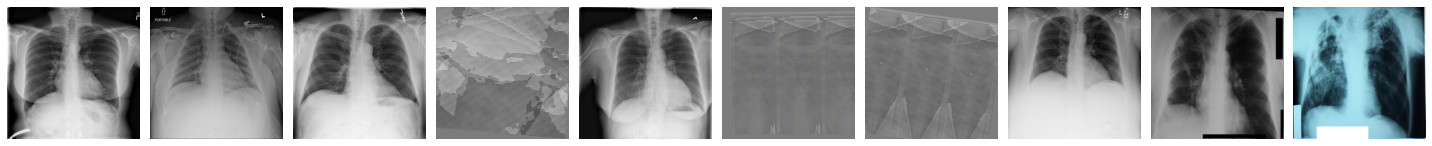

[0. 0. 0. 1. 0. 1. 1. 0. 1. 1.]


(10, 512, 512, 3)

In [13]:
imgs, labels=next(train_batches)
def plotImages(imgs_arr):
     fig,axes=plt.subplots(1,10,figsize=(20,20))
     axes=axes.flatten()
     for img,ax in zip(imgs_arr,axes):
         ax.imshow(img)
         ax.axis('off')
     plt.tight_layout()
     plt.show()
plotImages(imgs)
print(labels)
imgs.shape

**Early stopping and Saving the model**


I have applied early stopping by monitoring the validation loss for patience =3. If the validation loss does not improve(decreases) for the 3 consecutive epochs then the training will stop.
  

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

models_dir = "saved_models"
# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)
checkpointer = ModelCheckpoint( filepath='saved_models/model_cnn.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

# **1. Custom CNN:** 


First Model that I have applied is CNN model with 4 convolution layers and 2 dense layers with 1024 neurons each.



In [2]:

model=Sequential([Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(512,512,3)),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  tf.keras.layers.Dropout(0.5),
                 
                  Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  tf.keras.layers.Dropout(0.5),

                  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  tf.keras.layers.Dropout(0.5),
                  
                  Flatten(), 
                  Dense(256,activation='relu'),
                  Dense(256,activation='relu'),

                  Dense(units=1,activation='sigmoid'),
                 ])
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 32)      0

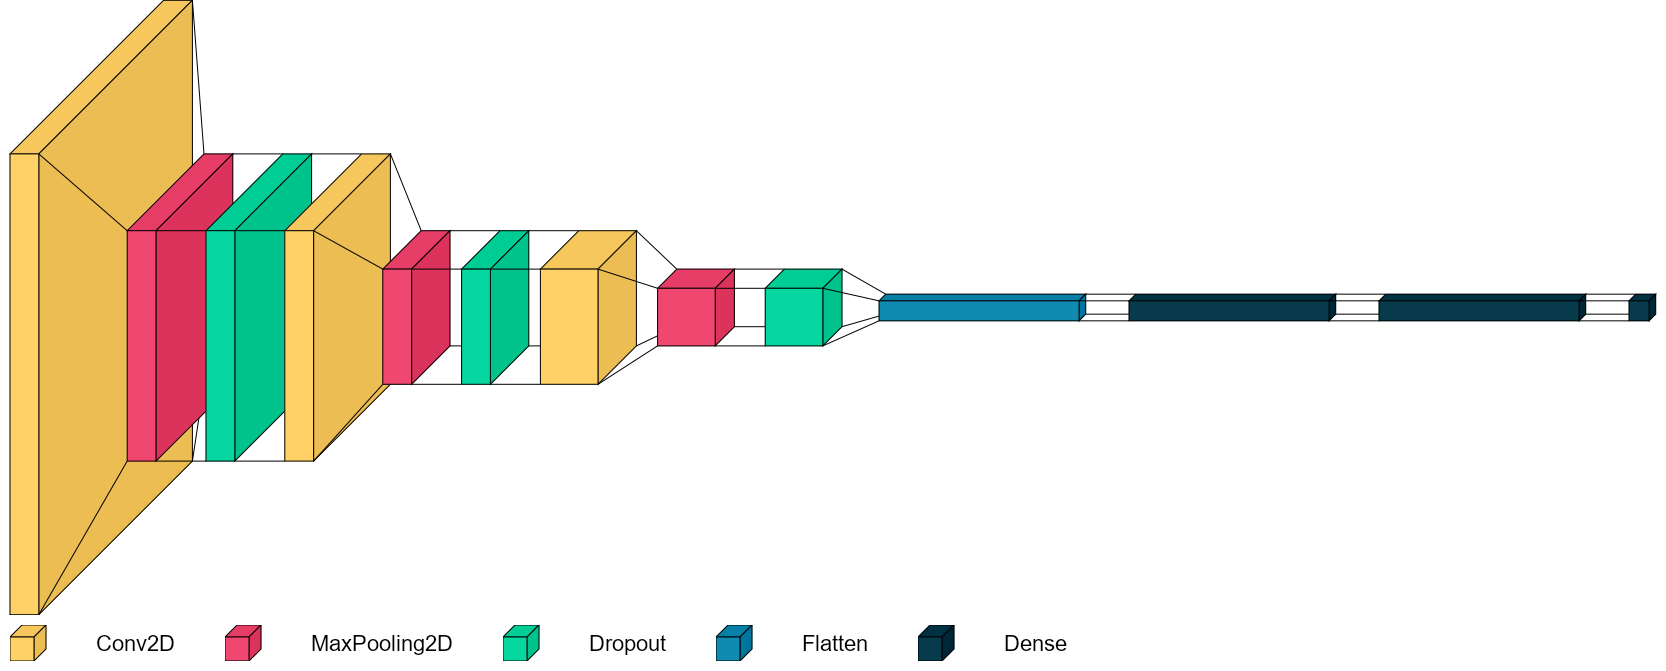

In [17]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 22) 
visualkeras.layered_view(model, legend=True, font=font,spacing=50, scale_xy=0.9, scale_z=0.9, max_z=200) 

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
start=time()
model_cnn=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
490/490 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9392
Epoch 00001: val_accuracy improved from -inf to 0.94929, saving model to saved_models\model_cnn.hdf5
490/490 [==============================] - 148s 270ms/step - loss: 0.1757 - accuracy: 0.9392 - val_loss: 0.4155 - val_accuracy: 0.9493 - lr: 1.0000e-04
Epoch 2/20
490/490 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9631
Epoch 00002: val_accuracy improved from 0.94929 to 0.95857, saving model to saved_models\model_cnn.hdf5
490/490 [==============================] - 86s 175ms/step - loss: 0.1007 - accuracy: 0.9631 - val_loss: 0.4196 - val_accuracy: 0.9586 - lr: 1.0000e-04
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9688
Epoch 00003: val_accuracy did not improve from 0.95857
490/490 [==============================] - 82s 168ms/step - loss: 0.0800 - accuracy: 0.9688 - val_loss: 0.3680 - val_accuracy: 0.9336 - lr: 1.0000e-0

**History**: Plotting model accuracy and loss for training and validation 

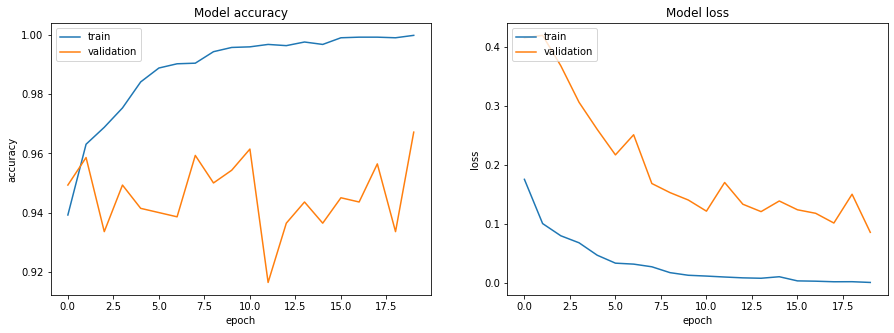

In [18]:
plot_training(model_cnn)

**Test Accuracy**: Feeding the test batches for calculating test accuracy

In [19]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
#test_batches.classes
model.load_weights('saved_models/model_cnn.hdf5')
score_cnn = model.evaluate(test_batches, verbose=1)
score_cnn

70/70 [==============================] - 14s 203ms/step - loss: 0.0728 - accuracy: 0.9771


[0.07277972996234894, 0.977142870426178]

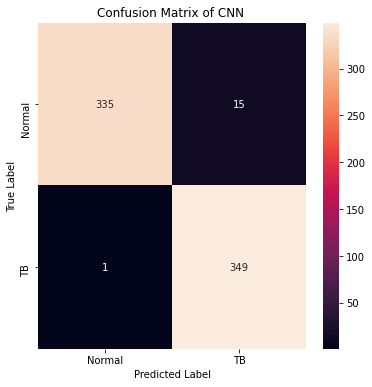

In [20]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of CNN ")
plt.show()

In [21]:
report_cnn = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_cnn = pd.DataFrame(report_cnn).transpose()
df_cnn

,precision,recall,f1-score,support
Normal,0.997024,0.957143,0.976676,350.000000
TB,0.958791,0.997143,0.977591,350.000000
accuracy,0.977143,0.977143,0.977143,0.977143
macro avg,0.977908,0.977143,0.977134,700.000000
weighted avg,0.977908,0.977143,0.977134,700.000000


# **2. VGG 16 Model**


Next, I have applied VGG 16 model through transfer learning.

In [2]:

def vgg(input_shape, n_classes):
  input = Input(input_shape)
  x = Conv2D(64, 3, padding='same', activation='relu')(input)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(28, 3, padding='same', activation='relu')(x)
  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)

  output = Dense(1, activation='sigmoid')(x)
  model = Model(input, output)
  return model




In [3]:
K.clear_session()
input_shape=(512,512,3)
n_classes=2
model=vgg(input_shape,n_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 28)      16156     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     32384     
                                                             

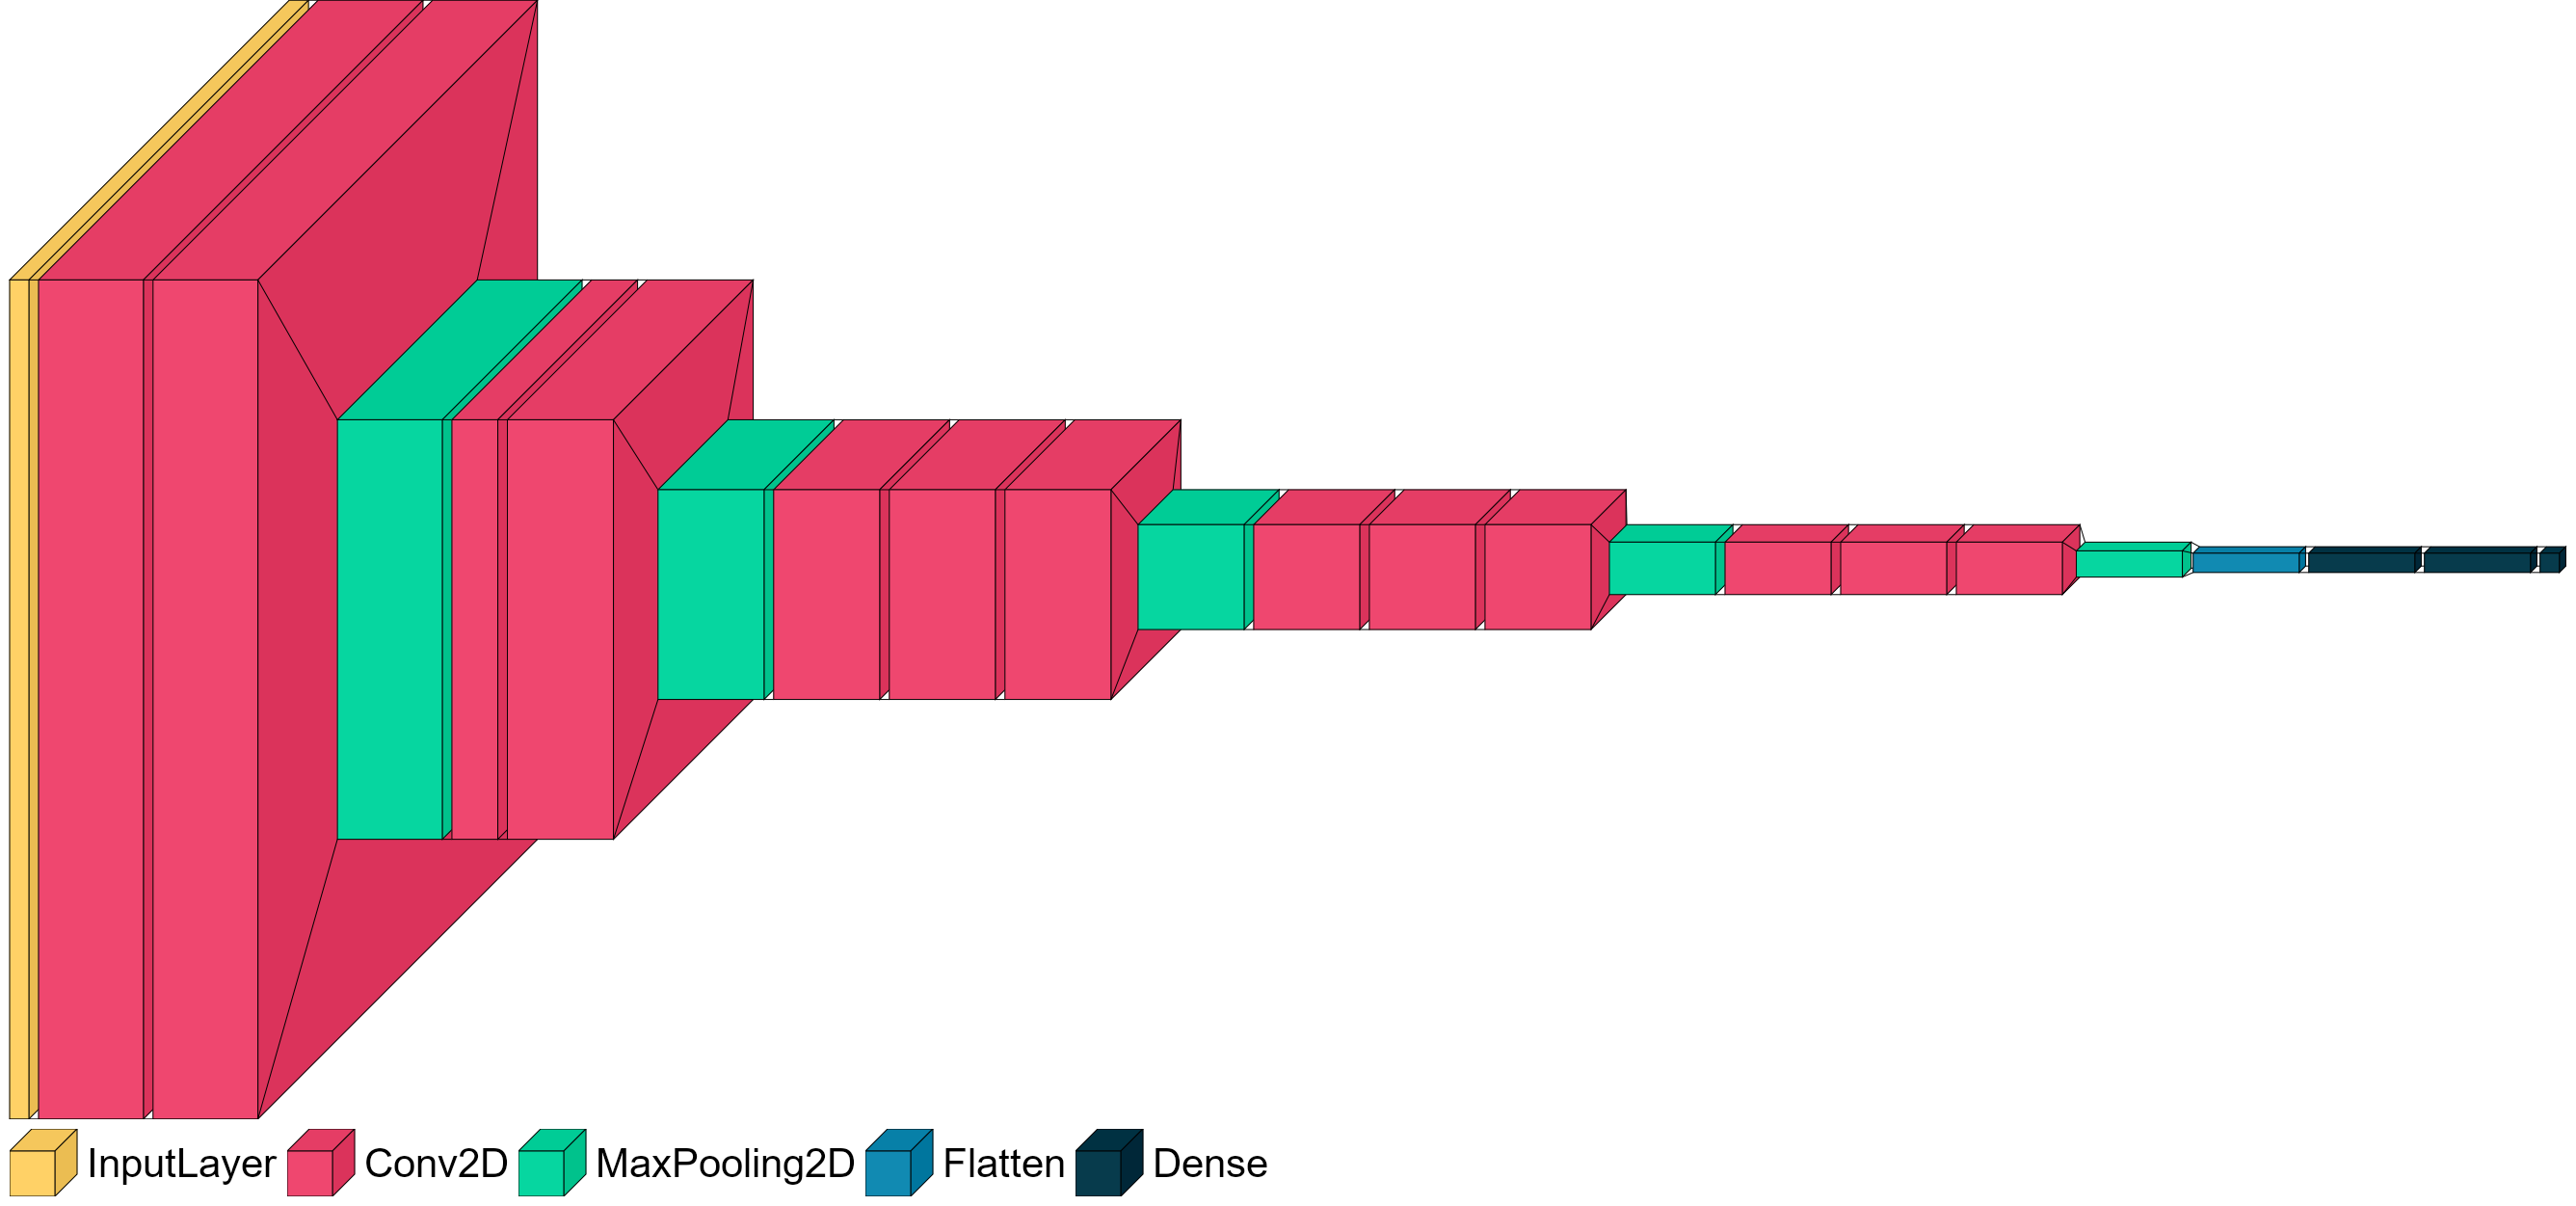

In [5]:
font = ImageFont.truetype("arial.ttf", 42) 
visualkeras.layered_view(model, legend=True, font=font,spacing=10, scale_xy=1.7, scale_z=1.7, max_z=110) 

In [24]:
checkpointer = ModelCheckpoint( filepath='saved_models/VGG_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
# Training of CNN VGG 16 model with 10 epochs
start=time()
VGG_model=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", round((end-start)/60,2)," Mins")

Epoch 1/20
490/490 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9018
Epoch 00001: val_accuracy improved from -inf to 0.95643, saving model to saved_models\VGG_model.hdf5
490/490 [==============================] - 143s 283ms/step - loss: 0.2637 - accuracy: 0.9018 - val_loss: 0.1067 - val_accuracy: 0.9564 - lr: 1.0000e-04
Epoch 2/20
490/490 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9345
Epoch 00002: val_accuracy did not improve from 0.95643
490/490 [==============================] - 122s 250ms/step - loss: 0.1671 - accuracy: 0.9345 - val_loss: 0.1056 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.9449
Epoch 00003: val_accuracy improved from 0.95643 to 0.96071, saving model to saved_models\VGG_model.hdf5
490/490 [==============================] - 138s 281ms/step - loss: 0.6217 - accuracy: 0.9449 - val_loss: 0.1073 - val_accuracy: 0.9607 - lr: 1.0000e

**History of VGG 16**

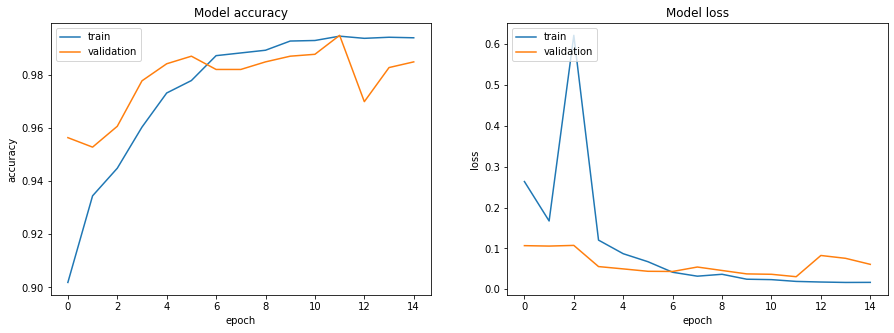

In [27]:
plot_training(VGG_model)

In [29]:
model=tf.keras.models.load_model('saved_models\\VGG_model.hdf5', compile=True)

**Test accuracy of VGG 16**

In [30]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
#test_batches.classes
model.load_weights('saved_models/VGG_model.hdf5')
score_vgg = model.evaluate(test_batches, verbose=1)
score_vgg

70/70 [==============================] - 15s 217ms/step - loss: 0.0379 - accuracy: 0.9886


[0.03791402652859688, 0.9885714054107666]

**Confusion Matrix of VGG 16**

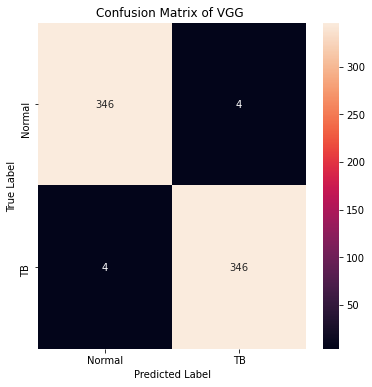

In [31]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of VGG ")
plt.show()

**Different Metrics of VGG 16**

In [33]:
report_vgg = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_vgg = pd.DataFrame(report_vgg).transpose()
df_vgg

,precision,recall,f1-score,support
Normal,0.988571,0.988571,0.988571,350.000000
TB,0.988571,0.988571,0.988571,350.000000
accuracy,0.988571,0.988571,0.988571,0.988571
macro avg,0.988571,0.988571,0.988571,700.000000
weighted avg,0.988571,0.988571,0.988571,700.000000


# **3. AlexNet**

In [6]:
def alexnet(input_shape, n_classes):
  input = Input(input_shape)
  x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(256, 5, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  
  output = Dense(1, activation='sigmoid')(x)
  
  model = Model(input, output)
  return model

In [7]:
K.clear_session()
input_shape=(512,512,3)
n_classes=2
model=alexnet(input_shape,n_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 256)      1024  

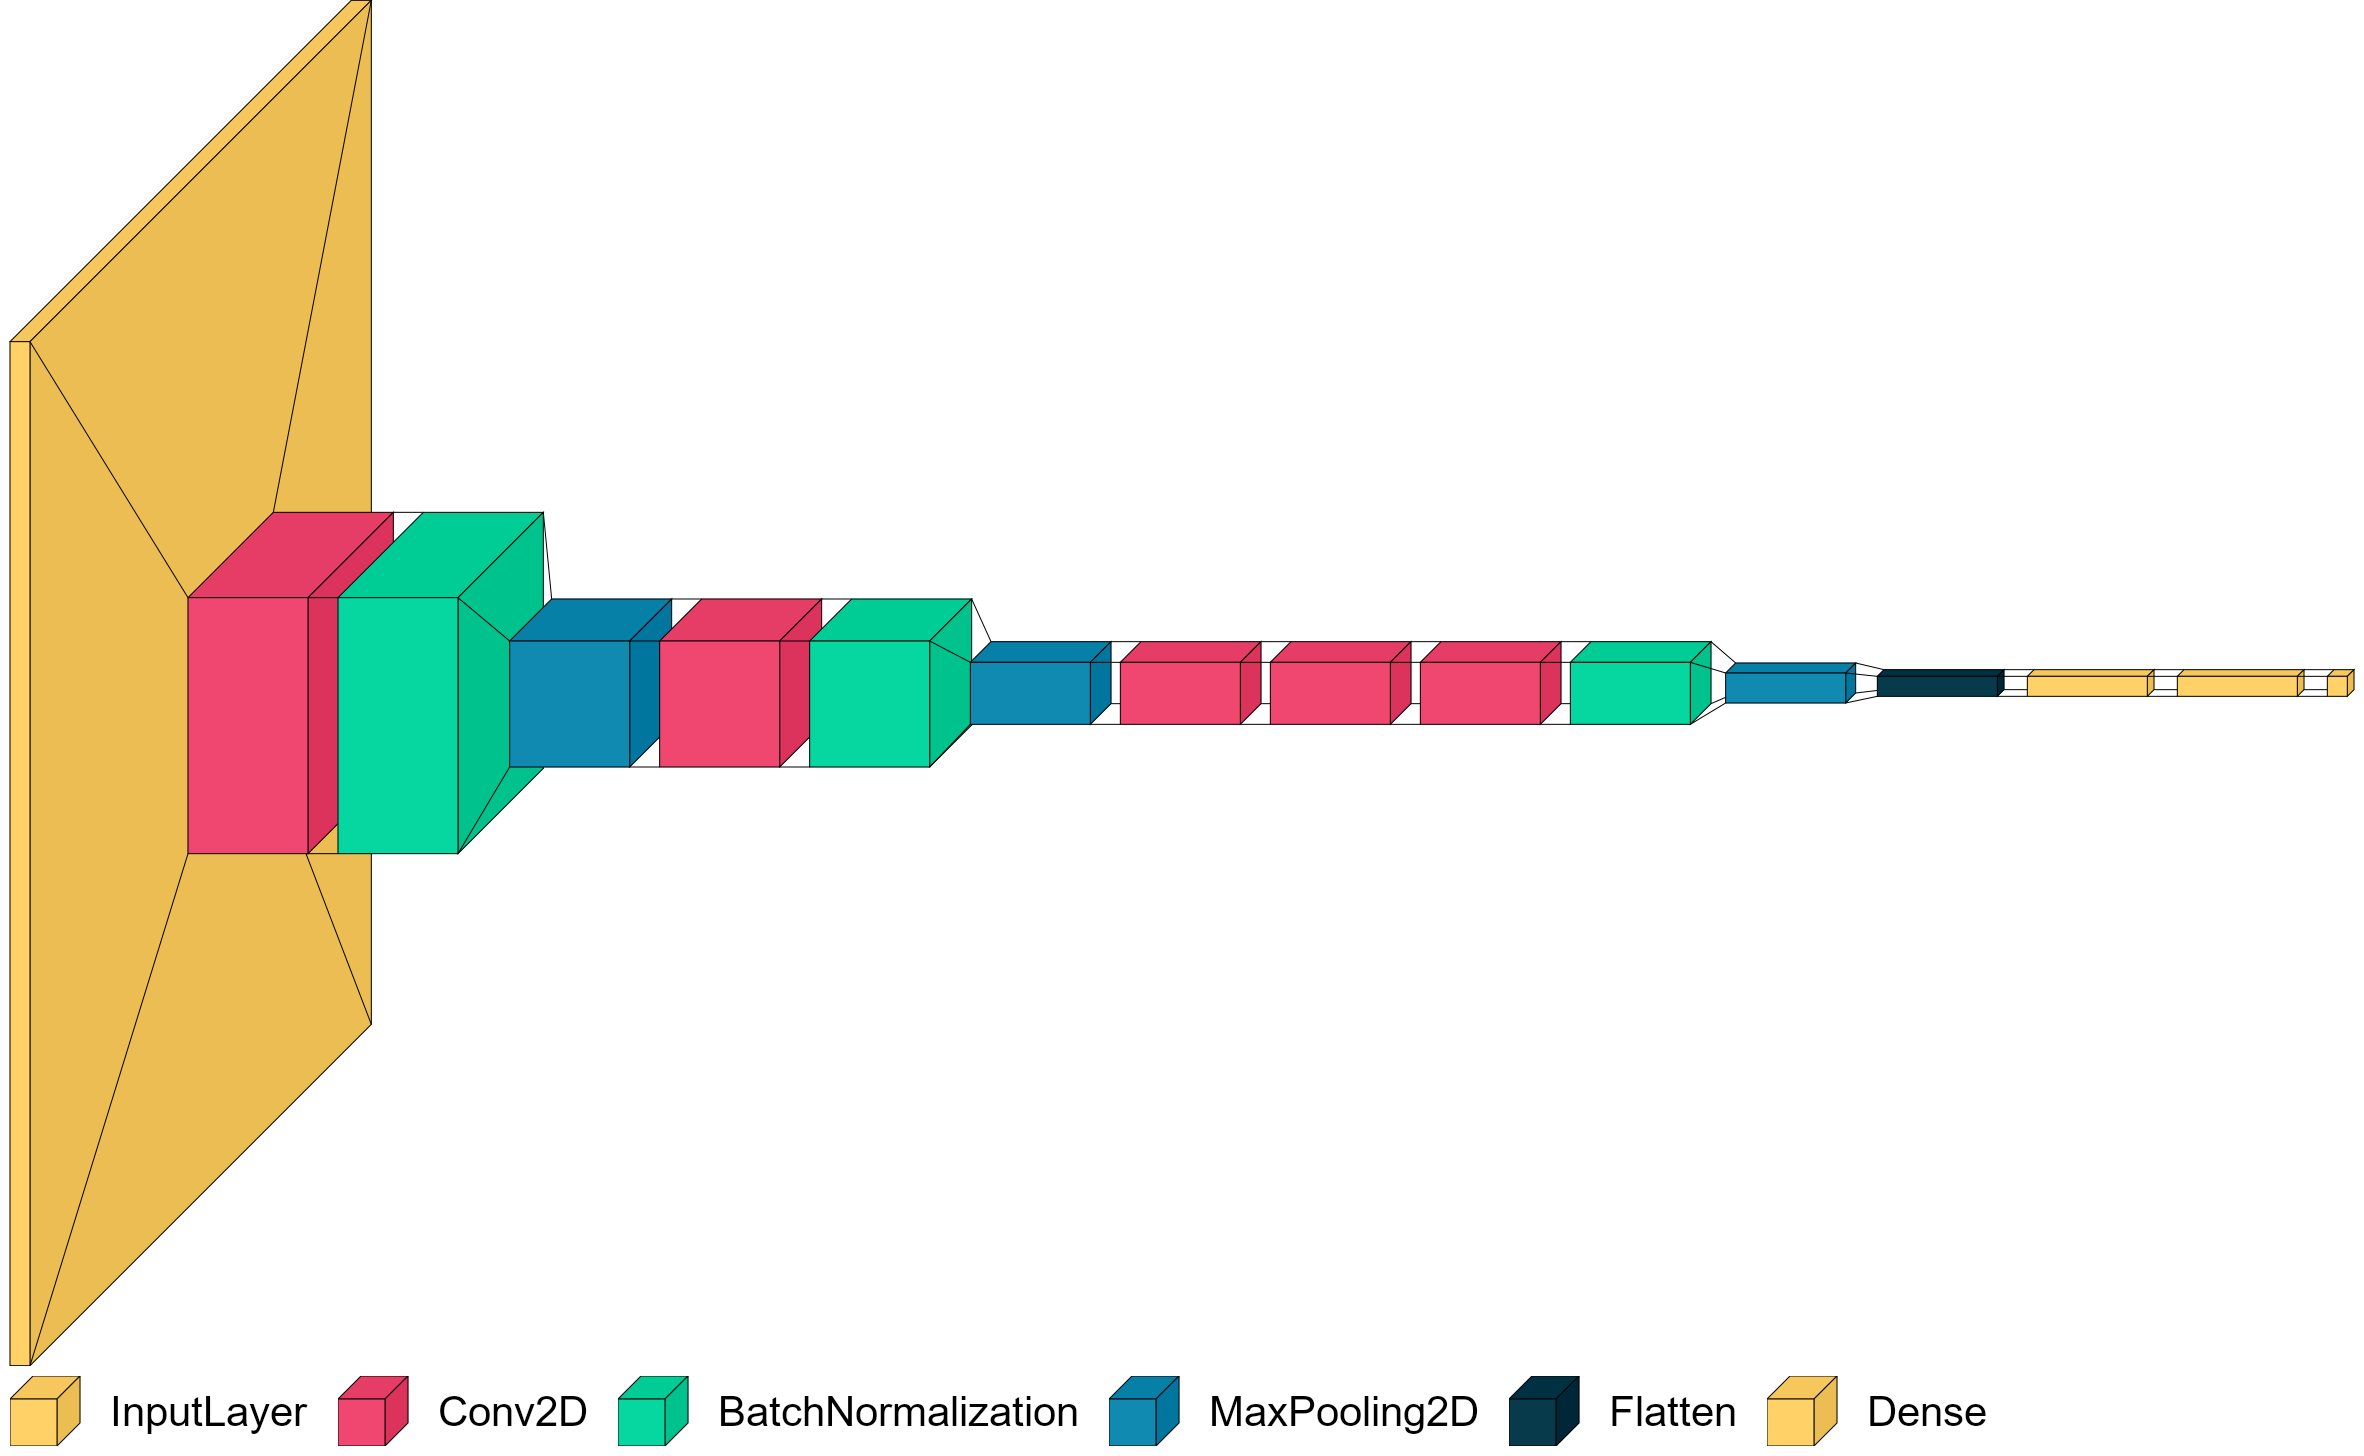

In [11]:
font = ImageFont.truetype("arial.ttf", 42) 
visualkeras.layered_view(model, legend=True, font=font,spacing=30, scale_xy=2, scale_z=2, max_z=120) 

In [36]:
checkpointer = ModelCheckpoint( filepath='saved_models/alex_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [38]:
start=time()
alex_model=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
490/490 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.9439
Epoch 00001: val_accuracy improved from -inf to 0.86000, saving model to saved_models\alex_model.hdf5
490/490 [==============================] - 138s 279ms/step - loss: 0.4105 - accuracy: 0.9439 - val_loss: 0.2978 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 2/20
490/490 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.9647
Epoch 00002: val_accuracy did not improve from 0.86000
490/490 [==============================] - 80s 163ms/step - loss: 0.2608 - accuracy: 0.9647 - val_loss: 78.3629 - val_accuracy: 0.8079 - lr: 1.0000e-04
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9686
Epoch 00003: val_accuracy improved from 0.86000 to 0.99071, saving model to saved_models\alex_model.hdf5
490/490 [==============================] - 88s 179ms/step - loss: 0.1479 - accuracy: 0.9686 - val_loss: 0.0318 - val_accuracy: 0.9907 - lr: 1.0000

**History of Alex Model**

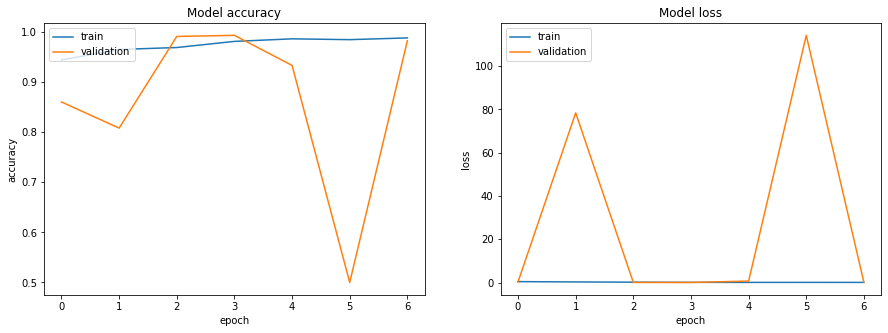

In [39]:
plot_training(alex_model)

**Test Accuracy of Alex Model**

In [40]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/alex_model.hdf5')
score_alex = model.evaluate(test_batches, verbose=1)
score_alex

70/70 [==============================] - 9s 129ms/step - loss: 0.0237 - accuracy: 0.9929


[0.0237068310379982, 0.9928571581840515]

**Confusion Matrix of Alex Model**

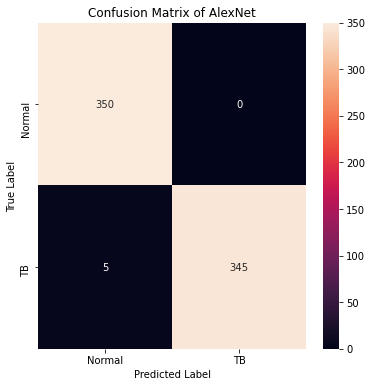

In [41]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of AlexNet")
plt.show()

**Different Metrics of Alex Model**

In [42]:
report_alex = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_alex = pd.DataFrame(report_alex).transpose()
df_alex

,precision,recall,f1-score,support
Normal,0.985915,1.000000,0.992908,350.000000
TB,1.000000,0.985714,0.992806,350.000000
accuracy,0.992857,0.992857,0.992857,0.992857
macro avg,0.992958,0.992857,0.992857,700.000000
weighted avg,0.992958,0.992857,0.992857,700.000000


# **4. Custom ANN Model-1**


Next, I have applied ANN model with 5 hidden layers.

In [43]:
model=Sequential()
model.add(Flatten(input_shape=(512,512,3)))

model.add(Dense(128,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(72,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(36,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 786432)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               100663424 
                                                                 
 dense_4 (Dense)             (None, 72)                9288      
                                                                 
 dense_5 (Dense)             (None, 36)                2628      
                                                                 
 dense_6 (Dense)             (None, 1)                 37        
                                                                 
Total params: 100,675,377
Trainable params: 100,675,377
Non-trainable params: 0
_________________________________________________________________


In [44]:
checkpointer = ModelCheckpoint( filepath='saved_models/ann_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [46]:
start=time()
ann_model=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
490/490 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.9102
Epoch 00001: val_accuracy improved from -inf to 0.94357, saving model to saved_models\ann_model.hdf5
490/490 [==============================] - 82s 166ms/step - loss: 0.4710 - accuracy: 0.9102 - val_loss: 0.2022 - val_accuracy: 0.9436 - lr: 1.0000e-04
Epoch 2/20
490/490 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9553
Epoch 00002: val_accuracy did not improve from 0.94357
490/490 [==============================] - 80s 163ms/step - loss: 0.1724 - accuracy: 0.9553 - val_loss: 0.5274 - val_accuracy: 0.8386 - lr: 1.0000e-04
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9435
Epoch 00003: val_accuracy improved from 0.94357 to 0.95071, saving model to saved_models\ann_model.hdf5
490/490 [==============================] - 84s 171ms/step - loss: 0.2497 - accuracy: 0.9435 - val_loss: 0.1466 - val_accuracy: 0.9507 - lr: 1.0000e-04

**History of ANN**

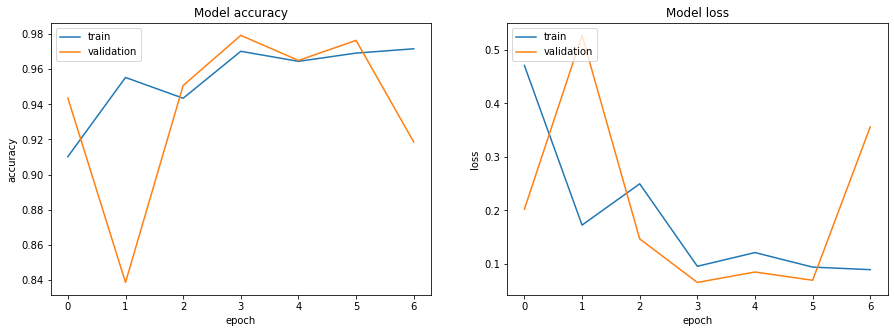

In [47]:
plot_training(ann_model)

**Test Accuracy of ANN**

In [48]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/ann_model.hdf5')
score_ann = model.evaluate(test_batches, verbose=1)
score_ann

70/70 [==============================] - 9s 126ms/step - loss: 0.0637 - accuracy: 0.9800


[0.06366752088069916, 0.9800000190734863]

**Confusion Matrix of ANN**

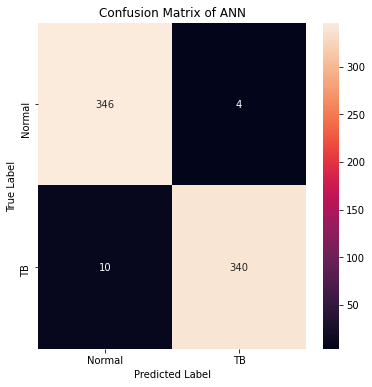

In [49]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of ANN")
plt.show()

In [50]:
report_ann = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_ann = pd.DataFrame(report_ann).transpose()
df_ann

,precision,recall,f1-score,support
Normal,0.971910,0.988571,0.980170,350.00
TB,0.988372,0.971429,0.979827,350.00
accuracy,0.980000,0.980000,0.980000,0.98
macro avg,0.980141,0.980000,0.979999,700.00
weighted avg,0.980141,0.980000,0.979999,700.00


# **5. Custom ANN Model-2**


In [51]:
model=Sequential()
model.add(Flatten(input_shape=(512,512,3)))

model.add(Dense(256,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(128,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(72,activation='relu'))
tf.keras.layers.Dropout(0.5),


model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 786432)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               201326848 
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 72)                9288      
                                                                 
 dense_10 (Dense)            (None, 1)                 73        
                                                                 
Total params: 201,369,105
Trainable params: 201,369,105
Non-trainable params: 0
_________________________________________________________________


In [52]:
checkpointer = ModelCheckpoint( filepath='saved_models/ann_2_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [53]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [54]:
start=time()
ann_model_2=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
490/490 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.9067
Epoch 00001: val_accuracy improved from -inf to 0.91857, saving model to saved_models\ann_2_model.hdf5
490/490 [==============================] - 87s 176ms/step - loss: 0.7506 - accuracy: 0.9067 - val_loss: 0.2884 - val_accuracy: 0.9186 - lr: 1.0000e-04
Epoch 2/20
490/490 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.9355
Epoch 00002: val_accuracy improved from 0.91857 to 0.95143, saving model to saved_models\ann_2_model.hdf5
490/490 [==============================] - 87s 178ms/step - loss: 0.3970 - accuracy: 0.9355 - val_loss: 0.2027 - val_accuracy: 0.9514 - lr: 1.0000e-04
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9451
Epoch 00003: val_accuracy improved from 0.95143 to 0.96786, saving model to saved_models\ann_2_model.hdf5
490/490 [==============================] - 84s 172ms/step - loss: 0.2861 - accuracy: 0.9451 - v

**History of ANN-2 Model**

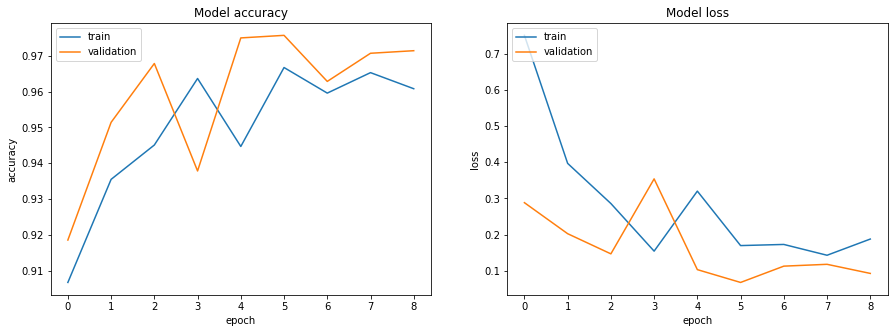

In [55]:
plot_training(ann_model_2)

**Test Accuracy of ANN-2 Model**

In [56]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/ann_2_model.hdf5')
score_ann_2 = model.evaluate(test_batches, verbose=1)
score_ann_2

70/70 [==============================] - 9s 126ms/step - loss: 0.0671 - accuracy: 0.9829


[0.06708638370037079, 0.9828571677207947]

**Confusion Matrix of ANN-2**

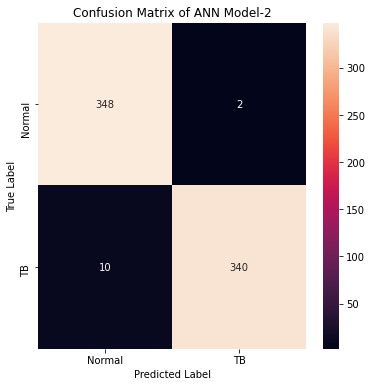

In [57]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of ANN Model-2")
plt.show()

**Different Metrics of ANN-2**

In [58]:
report_ann_2 = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_ann_2 = pd.DataFrame(report_ann_2).transpose()
df_ann_2

,precision,recall,f1-score,support
Normal,0.972067,0.994286,0.983051,350.000000
TB,0.994152,0.971429,0.982659,350.000000
accuracy,0.982857,0.982857,0.982857,0.982857
macro avg,0.983110,0.982857,0.982855,700.000000
weighted avg,0.983110,0.982857,0.982855,700.000000


# **6. Custom ANN Model-3**


In [59]:
model=Sequential()
model.add(Flatten(input_shape=(512,512,3)))

model.add(Dense(256,activation='relu'))

model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))

model.add(Dense(128,activation='relu'))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 786432)            0         
                                                                 
 dense_11 (Dense)            (None, 256)               201326848 
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 201,442,177
Trainable params: 201,442,17

In [60]:
checkpointer = ModelCheckpoint( filepath='saved_models/ann_3_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [61]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
start=time()
ann_model_3=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
490/490 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.9086
Epoch 00001: val_accuracy improved from -inf to 0.92214, saving model to saved_models\ann_3_model.hdf5
490/490 [==============================] - 85s 173ms/step - loss: 0.4485 - accuracy: 0.9086 - val_loss: 0.4048 - val_accuracy: 0.9221 - lr: 1.0000e-04
Epoch 2/20
490/490 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.9376
Epoch 00002: val_accuracy improved from 0.92214 to 0.93500, saving model to saved_models\ann_3_model.hdf5
490/490 [==============================] - 85s 173ms/step - loss: 0.3177 - accuracy: 0.9376 - val_loss: 0.2244 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9561
Epoch 00003: val_accuracy improved from 0.93500 to 0.97571, saving model to saved_models\ann_3_model.hdf5
490/490 [==============================] - 85s 173ms/step - loss: 0.1685 - accuracy: 0.9561 - v

**History of Custom ANN Model-3**

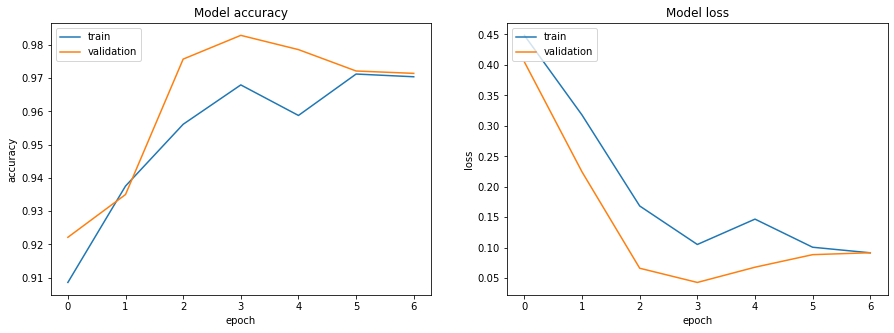

In [63]:
plot_training(ann_model_3)

**Test Accuracy of Custom ANN Model-3**

In [64]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/ann_3_model.hdf5')
score_ann_3 = model.evaluate(test_batches, verbose=1)
score_ann_3

70/70 [==============================] - 9s 131ms/step - loss: 0.0476 - accuracy: 0.9829


[0.047578997910022736, 0.9828571677207947]

**Confusion Matrix of ANN Model-3**

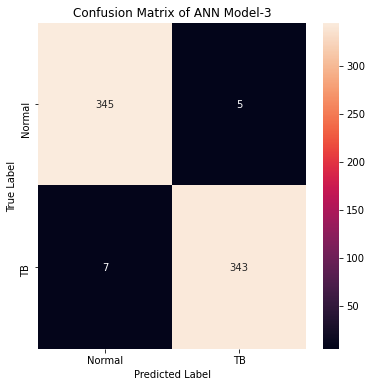

In [65]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of ANN Model-3")
plt.show()

**Different Metrics of ANN Model-3**

In [66]:
report_ann_3 = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_ann_3 = pd.DataFrame(report_ann_3).transpose()
df_ann_3

,precision,recall,f1-score,support
Normal,0.980114,0.985714,0.982906,350.000000
TB,0.985632,0.980000,0.982808,350.000000
accuracy,0.982857,0.982857,0.982857,0.982857
macro avg,0.982873,0.982857,0.982857,700.000000
weighted avg,0.982873,0.982857,0.982857,700.000000


In [67]:
#model=tf.keras.models.load_model('/content/drive/MyDrive/TB Data.zip (Unzipped Files)/TB Data/saved_models/model_cnn.hdf5', compile=True)